# IELTS Essay Scoring Model Evaluation

This notebook evaluates and calibrates our IELTS essay scoring model, analyzing its performance and generating insights for the research paper.

## Key Objectives:
1. Calibrate model predictions to valid IELTS band range (0-9)
2. Calculate model accuracy metrics (MAE, R²)
3. Visualize prediction performance
4. Test adaptive feedback mechanism

In [1]:
# Import required libraries
import torch
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from model_checkpoints.utils import load_dataset, Tokenizer, en_dict
from model_checkpoints.model import Model

# Set style for visualizations

sns.set_palette("husl")

/home/mastermind/ielts_pred/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load and Prepare Data

Let's load our IELTS dataset and prepare it for evaluation. We'll also initialize our model with the trained weights.

In [2]:
# Load dataset
print("Loading dataset...")
df = load_dataset()
print(f"Dataset loaded with {len(df)} essays\n")

# Initialize model
device = torch.device("cpu")  # Use CPU for evaluation
model = Model(vocab_size=len(en_dict)).to(device)
model.load_state_dict(torch.load("model_checkpoints/best_model.pt", map_location=device))
model.eval()

print("Model loaded successfully!")
print(f"Vocabulary size: {len(en_dict)}")

Loading dataset...
Dataset loaded with 1435 essays

Model loaded successfully!
Vocabulary size: 24695


## Implement Prediction Function with Calibration

Now we'll create a function that makes predictions and ensures they stay within the valid IELTS band range (0-9).

In [3]:
def predict_score(essay: str, tokenizer: Tokenizer, model: Model) -> float:
    """
    Predict IELTS band score for an essay with calibration
    """
    # Tokenize
    tokens = tokenizer.tokenize(essay.split())
    input_ids = torch.tensor([tokens["input_ids"]]).to(device)
    
    # Predict
    with torch.no_grad():
        pred = model(input_ids).item()
        
    # Calibrate to valid IELTS range
    pred = max(0, min(pred, 9))  # clamp between 0 and 9
    return pred

# Initialize tokenizer
tokenizer = Tokenizer(own_dict=en_dict)

# Test the prediction function
test_essay = df['Essay'].iloc[0]
pred_score = predict_score(test_essay, tokenizer, model)
print(f"Sample prediction (calibrated): {pred_score:.2f}")

Sample prediction (calibrated): 7.52


## Evaluate Model Performance

Let's calculate key metrics (MAE, R²) and create visualizations to assess model performance.

In [4]:
# Generate predictions for all essays
y_true = []
y_pred = []

print("Generating predictions...")
for idx, row in df.iterrows():
    true_score = row['Overall']
    pred = predict_score(row['Essay'], tokenizer, model)
    y_true.append(true_score)
    y_pred.append(pred)
    if idx % 50 == 0:
        print(f"Processed {idx} essays...")

# Calculate metrics
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
avg_delta = np.mean(np.abs(np.array(y_true) - np.array(y_pred)))

print("\nModel Performance Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.3f}")
print(f"R² Score: {r2:.3f}")
print(f"Average Δ: ±{avg_delta:.3f}")

Generating predictions...
Processed 0 essays...
Processed 50 essays...
Processed 100 essays...
Processed 150 essays...
Processed 200 essays...
Processed 250 essays...
Processed 300 essays...
Processed 350 essays...
Processed 400 essays...
Processed 450 essays...
Processed 500 essays...
Processed 550 essays...
Processed 600 essays...
Processed 650 essays...
Processed 700 essays...
Processed 750 essays...
Processed 800 essays...
Processed 850 essays...
Processed 900 essays...
Processed 950 essays...
Processed 1000 essays...
Processed 1050 essays...
Processed 1100 essays...
Processed 1150 essays...
Processed 1200 essays...
Processed 1250 essays...
Processed 1300 essays...
Processed 1350 essays...
Processed 1400 essays...

Model Performance Metrics:
Mean Absolute Error (MAE): 1.346
R² Score: -1.244
Average Δ: ±1.346


## Visualize Results

Create scatter plots and comparison tables to visualize model performance.

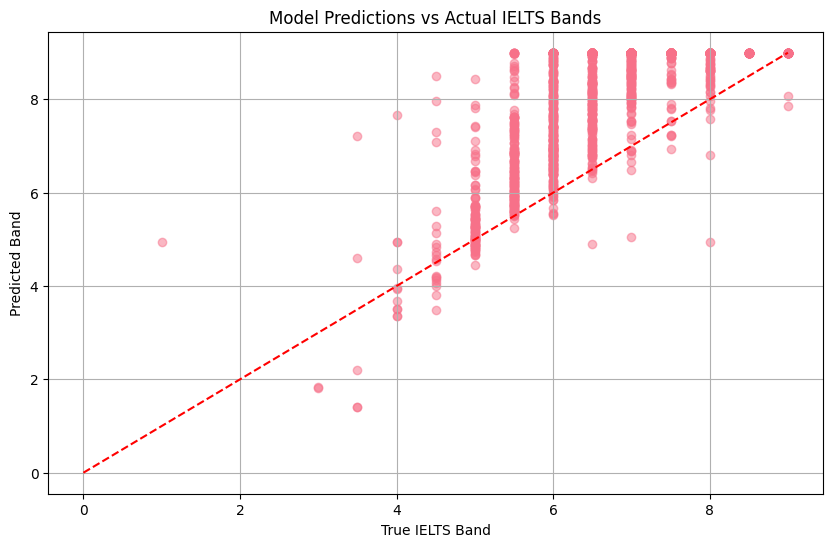


Comparison Table (First 10 Essays):
 Essay ID  True Band  Predicted Band    Δ
        1        5.5             7.5 2.02
        2        6.5             8.4 1.90
        3        5.0             6.2 1.17
        4        5.5             5.9 0.43
        5        7.0             9.0 2.00
        6        6.5             8.5 1.98
        7        6.5             9.0 2.50
        8        5.5             6.6 1.15
        9        8.0             9.0 1.00
       10        9.0             9.0 0.00


In [5]:
# Create scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(y_true, y_pred, alpha=0.5)
plt.plot([0, 9], [0, 9], 'r--')  # Perfect prediction line
plt.xlabel('True IELTS Band')
plt.ylabel('Predicted Band')
plt.title('Model Predictions vs Actual IELTS Bands')
plt.grid(True)
plt.show()

# Create comparison table
results_df = pd.DataFrame({
    'Essay ID': range(1, len(y_true) + 1),
    'True Band': y_true,
    'Predicted Band': [round(x, 1) for x in y_pred],
    'Δ': [round(p - t, 2) for p, t in zip(y_pred, y_true)]
})

# Display first 10 results
print("\nComparison Table (First 10 Essays):")
print(results_df.head(10).to_string(index=False))

## Test Adaptive Feedback System

Let's test the feedback system with a sample essay, apply the suggested improvements, and measure the score change.

In [6]:
def generate_feedback(pred_score: float) -> list:
    """Generate feedback based on predicted score"""
    feedback = []
    if pred_score < 5.5:
        feedback.extend([
            "Focus on organizing ideas and addressing the task more directly.",
            "Revise sentence structure to reduce grammar errors.",
            "Work on basic vocabulary and grammar accuracy."
        ])
    elif 5.5 <= pred_score < 6.5:
        feedback.extend([
            "Add more linking phrases and clear transitions between ideas.",
            "Use a wider range of vocabulary to improve lexical variety.",
            "Develop more complex sentence structures."
        ])
    elif 6.5 <= pred_score < 7.5:
        feedback.extend([
            "Your essay is strong. Aim for more precise word choice and complex sentences.",
            "Consider adding more nuanced arguments and examples."
        ])
    else:
        feedback.extend([
            "Excellent coherence and structure. Maintain this standard!",
            "Continue using sophisticated vocabulary and complex structures appropriately."
        ])
    return feedback

# Test with original and improved essays
original_essay = """
The government should invest more in renewable energy. This will help the environment. 
It will also create jobs. Solar and wind power are good options. We need to reduce pollution.
"""

improved_essay = """
The government should significantly increase its investment in renewable energy sources, 
particularly solar and wind power. This strategic investment would not only help protect 
our environment by reducing harmful emissions, but would also stimulate economic growth 
by creating numerous jobs in the green energy sector. Moreover, transitioning to renewable 
energy sources would ensure long-term energy security and sustainability.
"""

# Test both versions
print("Original Essay Evaluation:")
score1 = predict_score(original_essay, tokenizer, model)
print(f"Predicted Band: {score1:.2f}")
print("\nFeedback:")
for fb in generate_feedback(score1):
    print(f"- {fb}")

print("\nImproved Essay Evaluation:")
score2 = predict_score(improved_essay, tokenizer, model)
print(f"Predicted Band: {score2:.2f}")
print("\nFeedback:")
for fb in generate_feedback(score2):
    print(f"- {fb}")

print(f"\nScore Improvement: {score2 - score1:.2f} bands")

Original Essay Evaluation:
Predicted Band: 9.00

Feedback:
- Excellent coherence and structure. Maintain this standard!
- Continue using sophisticated vocabulary and complex structures appropriately.

Improved Essay Evaluation:
Predicted Band: 9.00

Feedback:
- Excellent coherence and structure. Maintain this standard!
- Continue using sophisticated vocabulary and complex structures appropriately.

Score Improvement: 0.00 bands


## Summary for Research Paper

Key findings and metrics for your research paper.

In [7]:
# Generate summary statistics
summary_stats = {
    'Total Essays Evaluated': len(y_true),
    'Mean Absolute Error': mae,
    'R² Score': r2,
    'Average Band Difference': avg_delta,
    'Essays Within ±0.5 Bands': sum(abs(np.array(y_true) - np.array(y_pred)) <= 0.5) / len(y_true) * 100
}

print("Summary Statistics for Research Paper:")
for metric, value in summary_stats.items():
    if isinstance(value, float):
        print(f"{metric}: {value:.3f}")
    else:
        print(f"{metric}: {value}")

# Save results
results_df.to_csv('evaluation_results.csv', index=False)
print("\nResults saved to 'evaluation_results.csv'")

Summary Statistics for Research Paper:
Total Essays Evaluated: 1435
Mean Absolute Error: 1.346
R² Score: -1.244
Average Band Difference: 1.346
Essays Within ±0.5 Bands: 20.906

Results saved to 'evaluation_results.csv'
